In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

In [2]:
# Paths to the directories
images_dir = '/group/jmearlesgrp/data/AGILE-Datasets/Flower-Detection/Synthetic/images_'
labels_dir = '/group/jmearlesgrp/data/AGILE-Datasets/Flower-Detection/Synthetic/labels_'
output_images_dir = '/group/jmearlesgrp/data/AGILE-Datasets/Flower-Detection/Synthetic/images'
output_labels_dir = '/group/jmearlesgrp/data/AGILE-Datasets/Flower-Detection/Synthetic/labels'

# Resize factor (0.5 for 50% reduction)
resize_factor = 0.5

# Ensure output directories exist
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

def resize_image_and_bbox(image_path, label_path, output_image_path, output_label_path, resize_factor):
    # Open the image
    image = Image.open(image_path)
    width, height = image.size
    
    # Calculate new dimensions
    new_width = int(width * resize_factor)
    new_height = int(height * resize_factor)
    
    # Resize the image
    resized_image = image.resize((new_width, new_height), Image.LANCZOS)
    resized_image.save(output_image_path)

    # Simply copy the YOLO label file without modifying the annotations
    with open(label_path, 'r') as label_file:
        lines = label_file.readlines()
    
    with open(output_label_path, 'w') as output_label_file:
        output_label_file.writelines(lines)

# Process each image and label pair in the directories
for filename in os.listdir(images_dir):
    if filename.endswith('.jpg') or filename.endswith('.jpeg'):  # Adjust extensions as needed
        image_path = os.path.join(images_dir, filename)
        label_filename = filename.replace('.jpg', '.txt').replace('.jpeg', '.txt')
        label_path = os.path.join(labels_dir, label_filename)
        
        output_image_path = os.path.join(output_images_dir, 'resized_' + filename)
        output_label_path = os.path.join(output_labels_dir, 'resized_' + label_filename)
        
        if os.path.exists(label_path):
            resize_image_and_bbox(image_path, label_path, output_image_path, output_label_path, resize_factor)
        else:
            print(f"Label file not found for {filename}")


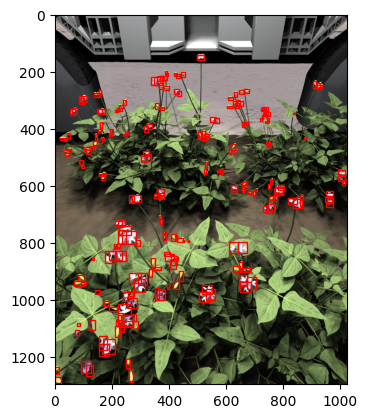

In [7]:
def plot_image_with_annotations(image_path, label_path):
    # Open the image
    image = Image.open(image_path)
    width, height = image.size
    
    # Plot the image
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    # Read bounding box annotations
    with open(label_path, 'r') as label_file:
        lines = label_file.readlines()
    
    for line in lines:
        # Parse the YOLO format: class_id, x_center, y_center, bbox_width, bbox_height
        class_id, x_center, y_center, bbox_width, bbox_height = map(float, line.strip().split())
        
        # Convert YOLO bbox format (relative) to actual pixel values
        x_center *= width
        y_center *= height
        bbox_width *= width
        bbox_height *= height
        
        # Calculate the top-left corner coordinates
        x_min = x_center - (bbox_width / 2)
        y_min = y_center - (bbox_height / 2)
        
        # Create a rectangle patch and add it to the plot
        rect = patches.Rectangle((x_min, y_min), bbox_width, bbox_height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

# Choose a random image from the directory
image_files = [f for f in os.listdir(output_images_dir) if f.endswith('.jpg') or f.endswith('.jpeg')]
if image_files:
    random_image = random.choice(image_files)
    image_path = os.path.join(output_images_dir, random_image)
    label_filename = random_image.replace('.jpg', '.txt').replace('.jpeg', '.txt')
    label_path = os.path.join(output_labels_dir, label_filename)
    
    # Check if the label file exists and plot
    if os.path.exists(label_path):
        plot_image_with_annotations(image_path, label_path)
    else:
        print(f"Label file not found for {random_image}")
else:
    print("No images found in the directory.")